In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

# Preprocessing

In [2]:
!pip install gdown

In [3]:
!gdown --id 19uL0NRTfV6NlOZogRXPNcnOITr8BjlqK

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19uL0NRTfV6NlOZogRXPNcnOITr8BjlqK
From (redirected): https://drive.google.com/uc?id=19uL0NRTfV6NlOZogRXPNcnOITr8BjlqK&confirm=t&uuid=f082041f-5b6c-4cdd-8029-deaea0cc52d0
To: /content/archive.zip
100% 86.0M/86.0M [00:01<00:00, 53.5MB/s]


In [4]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/c

In [5]:
root_folder = '/content/'

In [6]:
classes=["cardboard","glass","metal","paper","plastic","trash"]

In [7]:
data=[]

for c in classes:
    path = os.path.join(root_folder, "garbage classification/Garbage classification", c)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        # Read image
        img = cv2.imread(img_path)
        if img is not None:  # Ensure image is properly loaded
            # Resize image
            img = cv2.resize(img, (224, 224))
            # Append image and class index to data
            data.append([img, classes.index(c)])
        else:
            print(f"Failed to read image: {img_path}")

In [8]:
# Convert data list to NumPy arrays
images = np.array([item[0] for item in data])
class_indices = np.array([item[1] for item in data])

In [9]:
# Shuffle the data
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
class_indices = class_indices[indices]

In [10]:
X=[]
Y=[]
for x,y in data:
    X.append(x)
    Y.append(y)

In [11]:
x=np.array(X)
y=np.array(Y)
print(x.shape,y.shape)

(2527, 224, 224, 3) (2527,)


In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=4, stratify=y)

In [13]:
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1516, 224, 224, 3) (1516,)
(1011, 224, 224, 3) (1011,)


# Build DenseNet169 Model

In [14]:
model_denseNet169=tf.keras.applications.densenet.DenseNet169(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

58541896/58541896 [==============================] - 4s 0us/step


In [15]:
model_denseNet169.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [16]:
base_input3=model_denseNet169.layers[0].input
base_output3=model_denseNet169.layers[-2].output

final_output3 = layers.Dense(240)(base_output3)
final_output3 = layers.Activation('relu')(final_output3)
final_output3 = layers.Dense(128)(final_output3)
final_output3 = layers.Activation('relu')(final_output3)
final_output3 = layers.Dense(64)(final_output3)
final_output3 = layers.Activation('relu')(final_output3)
final_output3 = layers.Dense(6, activation='softmax')(final_output3)

In [17]:
new_model_denseNet169 = tf.keras.Model(inputs = base_input3, outputs = final_output3)

In [18]:
new_model_denseNet169.compile(loss="sparse_categorical_crossentropy", optimizer = "SGD", metrics = ["accuracy"])

# Train DenseNet169 Model

In [19]:
result_D=new_model_denseNet169.fit(x_train, y_train, epochs = 20,validation_data=(x_test, y_test))

Epoch 1/20
48/48 [==============================] - 108s 929ms/step - loss: 1.2415 - accuracy: 0.5495 - val_loss: 1.1300 - val_accuracy: 0.5480
Epoch 2/20
48/48 [==============================] - 26s 535ms/step - loss: 0.4914 - accuracy: 0.8621 - val_loss: 0.8360 - val_accuracy: 0.6647
Epoch 3/20
48/48 [==============================] - 25s 531ms/step - loss: 0.2138 - accuracy: 0.9492 - val_loss: 0.5552 - val_accuracy: 0.8012
Epoch 4/20
48/48 [==============================] - 25s 529ms/step - loss: 0.1005 - accuracy: 0.9835 - val_loss: 0.4704 - val_accuracy: 0.8388
Epoch 5/20
48/48 [==============================] - 25s 530ms/step - loss: 0.0459 - accuracy: 0.9967 - val_loss: 0.3681 - val_accuracy: 0.8714
Epoch 6/20
48/48 [==============================] - 24s 501ms/step - loss: 0.0330 - accuracy: 0.9974 - val_loss: 0.3605 - val_accuracy: 0.8853
Epoch 7/20
48/48 [==============================] - 24s 500ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.4299 - val_accuracy: 0.855

In [20]:
new_model_denseNet169.evaluate(x_test,y_test)

32/32 [==============================] - 4s 118ms/step - loss: 0.3065 - accuracy: 0.9080


[0.3064841032028198, 0.9080118536949158]

In [21]:
new_model_denseNet169.save("new_model_denseNet169.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


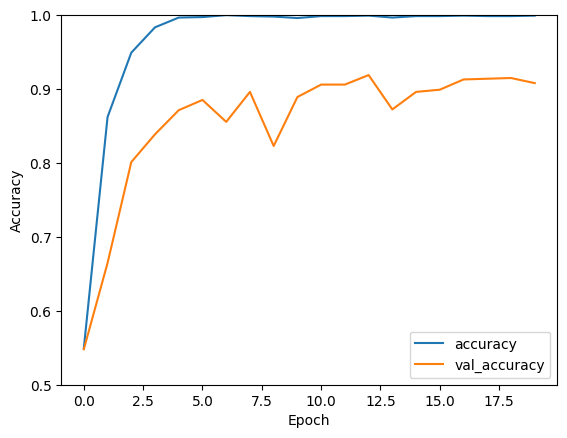

In [22]:
plt.plot(result_D.history['accuracy'], label='accuracy')
plt.plot(result_D.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Prediction

**I've noticed that DenseNet169 is the best model for this to predict with.**

In [26]:
pred=new_model_denseNet169.predict(x_test)

32/32 [==============================] - 6s 113ms/step


In [27]:
x1=[]
for i in range(len(pred)):
    x1.insert(i,np.argmax(pred[i]))

In [28]:
x1=np.array(x1)
x1

array([3, 0, 0, ..., 2, 0, 0])

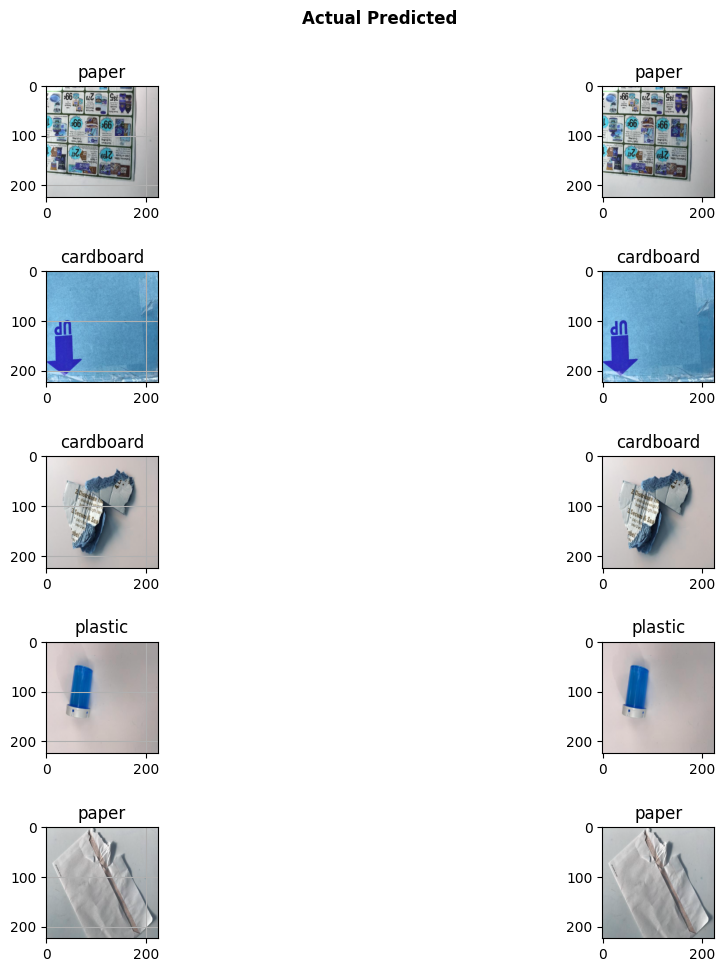

In [31]:
f, ax = plt.subplots(5,2,figsize=(15,10))
f.suptitle('Actual Predicted',fontsize = 12, fontweight ='bold')
a=0
b=1

for i in range(5):
    ax[i,a].imshow(x_test[i])
    ax[i,a].set_title(classes[y_test[i]])
    ax[i,b].imshow(x_test[i])
    ax[i,b].set_title(classes[x1[i]])
    ax[i,a].grid(True)
    ax[i,a].grid(True)


f.tight_layout(pad=2.0)
plt.show()